In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json, random, string, re
import matplotlib.cm as cm
import nltk
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# nltk.download('stopwords')
# nltk.download('punkt')

# Opens up JSON files from OCR results and puts/organizes them into json_data (Pandas data frame)

#files = os.listdir("./test_data")
files = os.listdir("./data")

json_data = pd.DataFrame(columns=['src_lang', 'text', 'file_name', 'meme_id'])

for index, js in enumerate(files):
    with open(os.path.join('./data', js)) as json_file:
        json_text = json.load(json_file)
        src_lang = json_text['src_lang']
        text = json_text['text']
        file_name = json_text['file_name']
        meme_id = json_text['id']
        json_data.loc[index] = [src_lang, text, file_name, meme_id]

In [185]:
# Clean up text column in terms of contractions, misspellings (e.g. thats -> that's or that is), remove numbers and 
# other non-alphabet characters, trims whitespace, and cleans up slang. 

def clean_column(data):
    if data is not None:
        data = data.lower()
        data = re.sub(r"\n", " ", data)
        data = re.sub(r"i'm", "i am", data)
        data = re.sub(r"\'re", " are", data)
        data = re.sub(r"\'d", " would", data)
        data = re.sub(r"\'ve", " have", data)
        data = re.sub(r"\'ll", " will", data)
        data = re.sub(r"can't", "cannot", data)
        data = re.sub(r" thats ", " that is ", data)
        data = re.sub(r"that's", "that is", data)
        data = re.sub(r" hes ", " he is ", data)
        data = re.sub(r" shes ", " she is ", data)
        data = re.sub(r"\'s", " is", data)
        data = re.sub(r"n\'t", " not", data)
        data = re.sub(r" ur ", " you are ", data)
        data = re.sub(r" u ", " you ", data)
        data = re.sub(r"[0-9]+", "", data)
        data = re.sub(r"[^\w\s]", "", data)
        data = re.sub(r" r ", " are ", data)
        data = re.sub(r" o ", " oh ", data)
        data = re.sub(r" aree ", " are ", data)
        return data

json_data['text'] = json_data['text'].apply(clean_column)

In [171]:
# Create stopwords. Initial set from WordCloud STOPWORDS then added more based on text data

stopwords = set(STOPWORDS)
stopwords.add('yoyou')
stopwords.add('rdankmemes')
stopwords.add('meme')
stopwords.add('memes')
stopwords.add('hoyou')
stopwords.add('rf')
stopwords.add('oh')
stopwords.add('one')

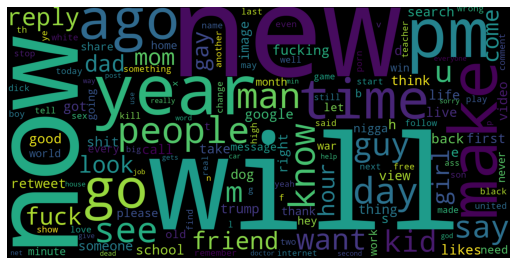

In [172]:
#
# Code taken from here (Kaggle - user DFoly1)
# https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch
#

# The word cloud shows the higher frequency words larger. Here, the maximum number is 150 and stopwords are not included.

wordcloud = WordCloud(
    collocations = False,
    width=1600, height=800,
    stopwords=stopwords,
    max_words=150,
    random_state=42
).generate(' '.join(json_data['text']))


print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [186]:
#
# Code taken from here (Kaggle user DFoly1)
# https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch
#
# Using NLTK, tokenize and stem using a Porter stemmer. Porter stemmer was chosen because it's quick and works with 
# English well.

# Parameter: text string
# Returns: tokenized and stemmed string

stemmer = PorterStemmer()

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [188]:
#
# Code taken from here (Kaggle user DFoly1)
# https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch
#

# Create TF-IDF vector here. The stopwords are the stopwords defined above. Maximum features can be varied. Default is None. 
# Different parameters for the TfidfVectorizer can be used like sublinear_tf or maximum/minimum term frequency. 
# Here is documentation for scikit-learn TfidfVectorizer:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

data = json_data['text']

# Define vectorizer
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=1000) #,tokenizer = tokenize_and_stem, sublinear_tf=True

# Apply it to data
tf_idf = tf_idf_vectorizer.fit_transform(data)

# Normalize input vectors individually to unit norm
tf_idf_norm = normalize(tf_idf)

# Make it an array
tf_idf_arr = tf_idf_norm.toarray()

# Print out shape
print(tf_idf_arr.shape)
# 3031 text vectors (3031 memes) and 1000 features (see max_features in the vectorizer definition)

# Print out feature names
pd.DataFrame(tf_idf_arr, columns=tf_idf_vectorizer.get_feature_names()).head()


(3031, 1000)


/home/skuretski/anaconda3/envs/cs410/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,able,abortion,accidentally,account,act,actually,ad,add,address,adult,...,year,years,yes,yet,yo,york,young,youre,youtube,ме
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.137595,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Initialization complete
Iteration 0, inertia 7.87330019815158
Iteration 1, inertia 6.858978661460845
Iteration 2, inertia 6.80093015237815
Iteration 3, inertia 6.794569002271348
Iteration 4, inertia 6.793122853135872
Iteration 5, inertia 6.792938655961399
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11.981729724193373
Iteration 1, inertia 6.802889468164273
Iteration 2, inertia 6.794569002271348
Iteration 3, inertia 6.793122853135872
Iteration 4, inertia 6.792938655961398
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14.341210115057375
Iteration 1, inertia 6.986740170873506
Iteration 2, inertia 6.800747805140696
Iteration 3, inertia 6.793668073446043
Iteration 4, inertia 6.792938655961398
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 7.200322237507968
Iteration 1, inertia 6.795326618393042
Iteration 2, inertia 6.793124620641087
Iteration 3, inertia 6.79

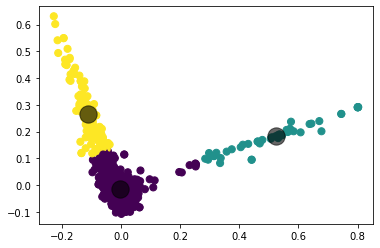

In [175]:
# Define your number of clusters for K-means here
num_clusters = 3

# Do PCA to reduce dimensionality
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_arr)

# Define our K-means. Many different parameters can be used with scikit KMeans version
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(verbose=1, n_clusters= num_clusters, n_init=20, max_iter=600, algorithm = 'full')

# Do K-means on the data (fit and predict)
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

# Show it
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')
centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

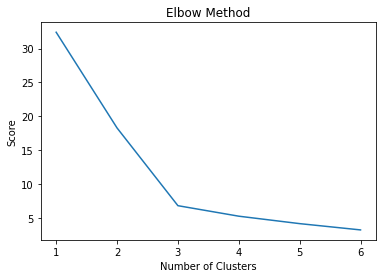

In [176]:
# Elbow method evaluation
# The "bend" in the curve gives a good estimate where the best number of clusters is

number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score') # Score is a function of variance
plt.title('Elbow Method')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.8889754028638381
For n_clusters = 3 The average silhouette_score is : 0.8455796790728813
For n_clusters = 4 The average silhouette_score is : 0.7425241922905894
For n_clusters = 5 The average silhouette_score is : 0.7454135135675463
For n_clusters = 6 The average silhouette_score is : 0.46500951238971544


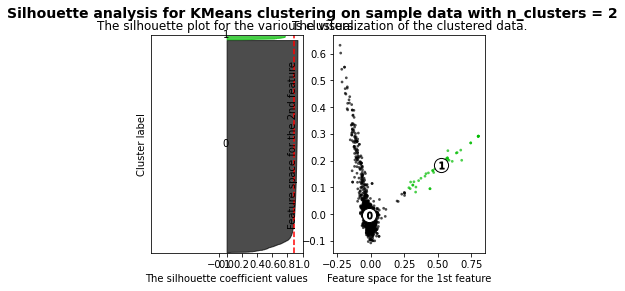

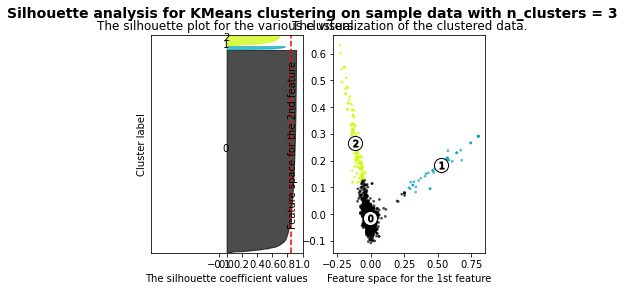

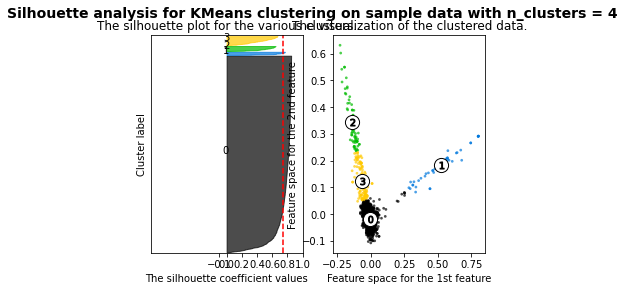

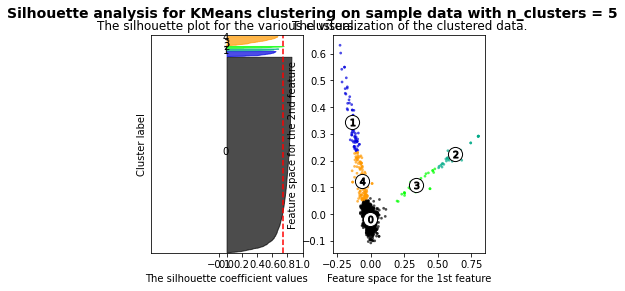

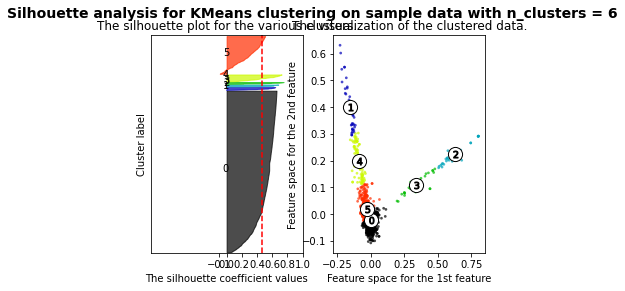

In [180]:
# Silhouette analysis
#
# Code for silhouette analysis taken from here: 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
#

# Sihouette analysis measures the separation distance between clusters. The value can be -1 to 1 where:
# < 0 means sample was assigned to wrong cluster
# 0 means the sample is very close to the boundary
# > 0 means the sample is far away from neighboring clusters (1 is optimal)

# Silhouette analysis done for cluster size of 2-6. Generally, the best cluster size is the one with the number closest to 1

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from [-1, 1] 
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(Y_sklearn) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Y_sklearn)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Y_sklearn, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Y_sklearn, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
    

In [181]:
# Code taken from
# https://www.kaggle.com/dfoly1/k-means-clustering-from-scratch
#
# Gets the top features of the clusters by sorting the indices with the top 20 scores
# Parameters: tf_idf_arr, prediction, number of features
# Returns: clusters with sorted top features

def get_top_features_cluster(tf_idf_arr, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_arr[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_arr, prediction, 20)

<AxesSubplot:xlabel='score', ylabel='features'>

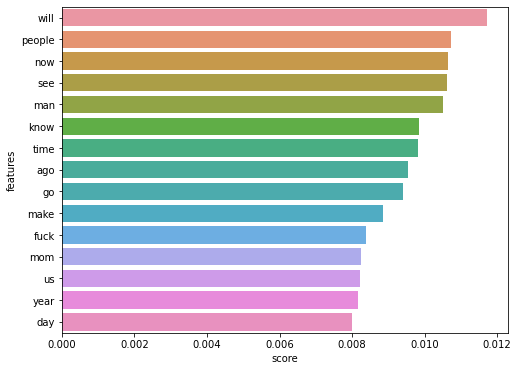

In [182]:
# Show top features
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

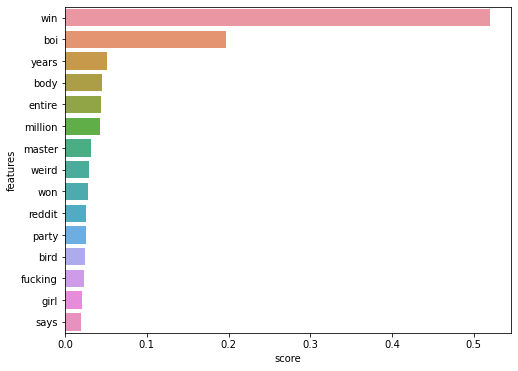

In [183]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

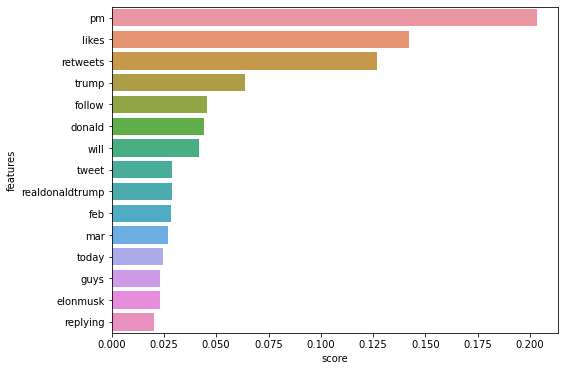

In [184]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])